## DB connection 

In [1]:
from pymongo import MongoClient
import matplotlib.pyplot as plt

client = MongoClient() # we run on localhost and default port
db = client['spotify']

## Get collections

In [2]:
features = db['features']
tracks   = db['tracks']
artists  = db['artists']
albums   = db['albums']


In [3]:
print(features) 
print(tracks  ) 
print(artists ) 
print(albums  ) 

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'spotify'), 'features')
Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'spotify'), 'tracks')
Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'spotify'), 'artists')
Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'spotify'), 'albums')


## Query 1
#### Query: Style the top 10 artists with the highest average album popularity

In [7]:
artists.create_index([("id", 1)])

'id_1'

In [8]:
query1 = [
  {
    '$match': {
      'album_type': "album"
    }
  },
  {
    '$group': {
      '_id': "$artist_id",
      'averageAlbumPopularity': { '$avg': "$album_popularity" }
    }
  },
  {
    '$lookup': {
      'from': "artists",
      'localField': "_id",
      'foreignField': "id",
      'as': "artistInfo"
    }
  },
  {
    '$unwind': "$artistInfo"
  },
  {
    '$project': {
      '_id': 0,
      'artist_id': "$_id",
      'artist_name': "$artistInfo.name",
      'averageAlbumPopularity': 1
    }
  },
  {
    '$sort': {
      'averageAlbumPopularity': -1
    }
  },
  {
    '$limit': 10
  }
]
result_query1 = list(albums.aggregate(query1))

In [9]:
result_query1

[{'averageAlbumPopularity': 90.0,
  'artist_id': '2uYWxilOVlUdk4oV9DvwqK',
  'artist_name': 'Mitski'},
 {'averageAlbumPopularity': 89.33962264150944,
  'artist_id': '4q3ewBCX7sLwd24euuV69X',
  'artist_name': 'Bad Bunny'},
 {'averageAlbumPopularity': 88.11428571428571,
  'artist_id': '6KImCVD70vtIoJWnq6nGn3',
  'artist_name': 'Harry Styles'},
 {'averageAlbumPopularity': 86.0,
  'artist_id': '3WGpXCj9YhhfX11TToZcXP',
  'artist_name': 'Troye Sivan'},
 {'averageAlbumPopularity': 85.0,
  'artist_id': '0iEtIxbK0KxaSlF7G42ZOp',
  'artist_name': 'Metro Boomin'},
 {'averageAlbumPopularity': 84.72340425531915,
  'artist_id': '53XhwfbYqKCa1cC15pYq2q',
  'artist_name': 'Imagine Dragons'},
 {'averageAlbumPopularity': 84.0,
  'artist_id': '487N2T9nIPEHrlTZLL3SQs',
  'artist_name': 'Zé Neto & Cristiano'},
 {'averageAlbumPopularity': 84.0,
  'artist_id': '1McMsnEElThX1knmY4oliG',
  'artist_name': 'Olivia Rodrigo'},
 {'averageAlbumPopularity': 82.0,
  'artist_id': '164Uj4eKjl6zTBKfJLFKKK',
  'artist_na

## Query 2
#### Query: Evolution of song's explicitness over the years (from 1960 on)
Indexes were created to speed up a such heavy query

In [ ]:
tracks.createIndex([( "id": 1 )])
features.createIndex([( "id": 1 )])
albums.createIndex([( "track_id": 1 )])
albums.createIndex([( "release_date": 1 )])


To check that indexes were actually used, after the aggregate operation:
```
.explain("executionStats");
```
And the debug was successful. Without indexes the result couldn't be observed due to the long execution time needed.


In [4]:
from bson import ObjectId
import datetime

query2 = [
    {
        '$lookup': {
            'from': 'features',
            'localField': 'id',
            'foreignField': 'id',
            'as': 'track_features'
        }
    },
    {
        '$unwind': '$track_features'
    },
    {
        '$lookup': {
            'from': 'albums',
            'localField': 'id',
            'foreignField': 'track_id',
            'as': 'album_info'
        }
    },
    {
        '$unwind': '$album_info'
    },
    {
        '$match': {
            'album_info.release_date': {'$gte': datetime.datetime(1960, 1, 1)}
        }
    },
    {
        '$group': {
            '_id': {
                'year': {'$year': '$album_info.release_date'},
                'explicit': '$explicit'
            },
            'totalTracks': {'$sum': 1}
        }
    },
    {
        '$group': {
            '_id': '$_id.year',
            'explicitCount': {
                '$sum': {
                    '$cond': [{'$eq': ['$_id.explicit', True]}, '$totalTracks', 0]
                }
            },
            'implicitCount': {
                '$sum': {
                    '$cond': [{'$eq': ['$_id.explicit', False]}, '$totalTracks', 0]
                }
            },
            'totalTracks': {'$sum': '$totalTracks'}
        }
    },
    {
        '$project': {
            '_id': 0,
            'year': '$_id',
            'explicitPercentage': {
                '$multiply': [
                    {'$divide': ['$explicitCount', '$totalTracks']},
                    100
                ]
            },
            'implicitPercentage': {
                '$multiply': [
                    {'$divide': ['$implicitCount', '$totalTracks']},
                    100
                ]
            }
        }
    },
    {
        '$sort': {'year': 1}
    }
]

result_query2 = list(tracks.aggregate(query2))

In [5]:
result_query2


[{'year': 1960, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1961, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1962, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1963, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1964, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1965, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1966, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1967, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1968, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1969, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1970, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1971,
  'explicitPercentage': 0.16260162601626016,
  'implicitPercentage': 99.83739837398375},
 {'year': 1972, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1973,
  '

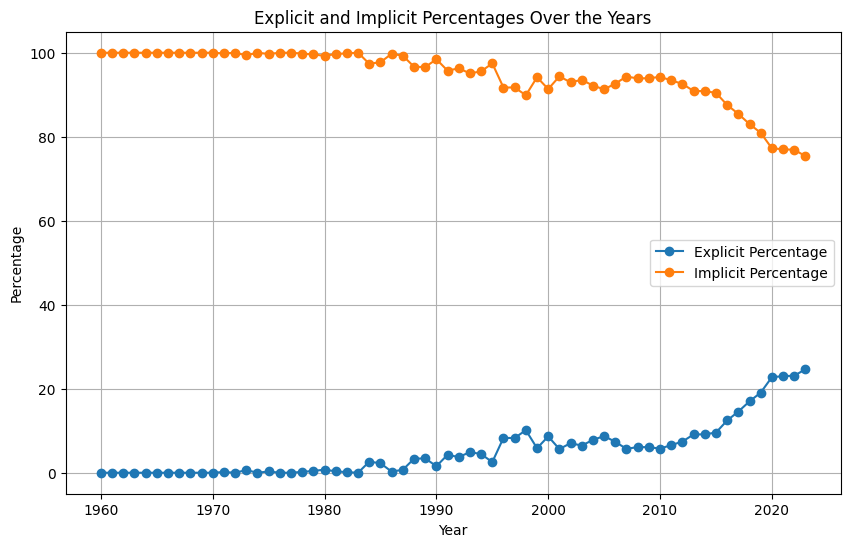

In [8]:
years                = [entry['year']               for entry in result_query2]
explicit_percentages = [entry['explicitPercentage'] for entry in result_query2]
implicit_percentages = [entry['implicitPercentage'] for entry in result_query2]

plt.figure(figsize=(10, 6))
plt.plot(years, explicit_percentages, label='Explicit Percentage', marker='o')
plt.plot(years, implicit_percentages, label='Implicit Percentage', marker='o')

plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Explicit and Implicit Percentages Over the Years')
plt.legend()
plt.grid(True)
plt.show()

## Query 3: get the average instrumentalness of the tracks based on its time signature,

In [9]:
query3 = [
    {
        '$group': {
            '_id': '$time_signature',
            'average_danceability': {'$avg': '$danceability'},
            'average_energy': {'$avg': '$energy'},
            'average_valence': {'$avg': '$valence'}
        }
    },
    {
        '$sort': {
            '_id': 1
        }
    },
    {
        '$project': {
            '_id': 0,
            'time_signature': '$_id',
            'average_danceability': 1,
            'average_energy': 1,
            'average_valence': 1
        }
    }
]

In [11]:
result_query3 = list(features.aggregate(query3))

In [16]:
for entry in result_query3:
    print(entry)

{'average_danceability': 0.003404432132963989, 'average_energy': 0.26101595844875347, 'average_valence': 0.002557756232686981, 'time_signature': 0}
{'average_danceability': 0.4136496569037657, 'average_energy': 0.36219480560669454, 'average_valence': 0.3145970180753138, 'time_signature': 1}
{'average_danceability': 0.43975479951664287, 'average_energy': 0.3548632672547512, 'average_valence': 0.3370189773393387, 'time_signature': 3}
{'average_danceability': 0.5977182066425011, 'average_energy': 0.5571829159586544, 'average_valence': 0.47963527953251917, 'time_signature': 4}
{'average_danceability': 0.4467058143296135, 'average_energy': 0.39166122789099145, 'average_valence': 0.3187189199417758, 'time_signature': 5}


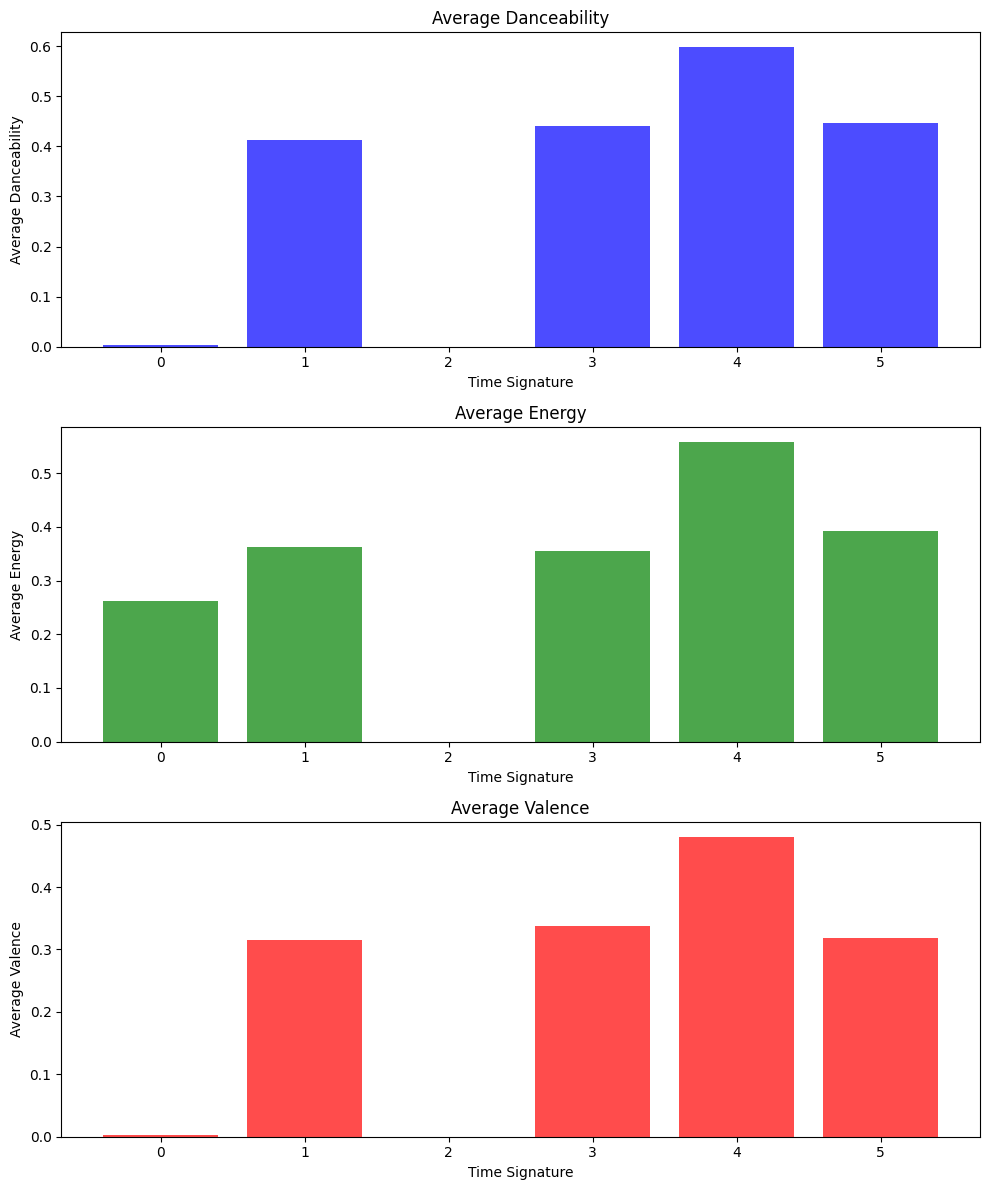

In [20]:


danceability    = [entry['average_danceability'] for entry in result_query3]
energy          = [entry['average_energy'] for entry in result_query3]
valence         = [entry['average_valence'] for entry in result_query3]
time_signatures = [entry['time_signature'] for entry in result_query3]

# Plotting histograms
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot for Average Danceability
axs[0].bar(time_signatures, danceability, color='blue', alpha=0.7)
axs[0].set_title('Average Danceability')
axs[0].set_xlabel('Time Signature')
axs[0].set_ylabel('Average Danceability')

# Plot for Average Energy
axs[1].bar(time_signatures, energy, color='green', alpha=0.7)
axs[1].set_title('Average Energy')
axs[1].set_xlabel('Time Signature')
axs[1].set_ylabel('Average Energy')

# Plot for Average Valence
axs[2].bar(time_signatures, valence, color='red', alpha=0.7)
axs[2].set_title('Average Valence')
axs[2].set_xlabel('Time Signature')
axs[2].set_ylabel('Average Valence')

plt.tight_layout()
plt.show()